# Building up to Frequency Modulation

[Wikipedia article on FM in general](https://en.wikipedia.org/wiki/Frequency_modulation)

[Wikipedia article on FM broadcast](https://en.wikipedia.org/wiki/FM_broadcasting)

[FM vs PM](https://www.allaboutcircuits.com/technical-articles/understanding-the-differences-between-phase-and-frequency-modulation/)

Let's start by trying to generate a real FM signal. Recall that in RF we start with a "carrier frequency," which is relatively high and is chosen by legal/financial (what the government is willing to give you) and technical concerns (some frequencies travel better than others). For WMBR, MIT's broadcast FM radio station, the carrier frequency is 88.1 MHz. We then use _modulation_ to apply a _baseband_ signal containing the information we want to transmit. _Baseband_ is the generic term for the information we want to transmit. For broadcast FM, the baseband signal is audio (plus some other information that gets you things like stereo audio and RDS).

__In FM, the instantaneous value of the baseband signal should cause the frequency of the signal to change proportionally.__

The _maximum modulating frequency_ is the maximum frequency present in the baseband signal. Human hearing goes to about 20 kHz, but broadcast FM's maximum modulating frequency is actually around 60 kHz to allow for the inclusion of extra information like stereo audio and RDS.

We will call the carrier frequency in Hz $ f_{\text{carrier}} $. In rad/sec, it's $ \omega_{\text{carrier}} = 2 \pi f_{\text{carrier}} $. This is typically constant; the carrier frequency of a signal does not move around during a transmission, unless you're doing things like frequency hopping for military/counterintelligence reasons.

We will call the baseband or "message" signal $ m(t) $. Note that this is typically time-varying; we encode useful information like audio by varying this signal.

So the equation for the real waveform (the voltages that the ADC receives from the antenna) from just a pure carrier would be:

$$ V(t) = \sin(\omega_{\text{carrier}} t) $$

In the time domain, this would be a sine wave. In the frequency domain, it would be a single spike at $ \omega_c $. The most obvious way to try to achieve FM would be to add something inside the $ \sin() $ corresponding to the message:

$$ V_{\text{PM}}(t) = \sin(\omega_{\text{carrier}} t + m(t)) $$

But it is immediately clear that this is not FM. This is just adding a phase offset but keeping the frequency the same. Let's see what that might look like for a square wave baseband message "1010":

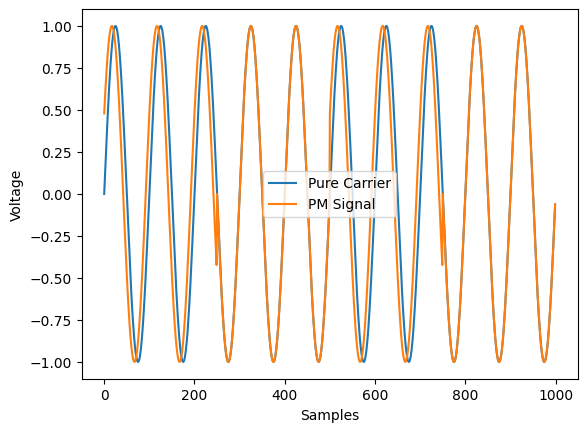

In [11]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt

sample_rate_hz = 1e3 # 1 kSps ADC sample rate
carrier_frequency_hz = 10 # 10 Hz carrier (much lower than actual carriers for demonstrational purposes)
capture_duration_s = 1 # Simulate capturing 1 second of data from ADC

message = np.array([0.5] * 250 + [0] * 250 + [0.5] * 250 + [0] * 250) # 1000 samples representing the signal 1010, where each bit lasts 250 samples. 0.5 radians is our "1"," 0 radians is our "0."

sample_times_s = np.arange(0, capture_duration_s, capture_duration_s / sample_rate_hz) # Timestamps in seconds each ADC sample
pure_carrier_signal = np.sin(2 * math.pi * carrier_frequency_hz * sample_times_s) # V(t) = sin(omega_carrier * t)
pm_signal = np.sin(2 * math.pi * carrier_frequency_hz * sample_times_s + message) # V_PM(t) = sin(omega_carrier * t + m(t))

plt.plot(pure_carrier_signal, label = "Pure Carrier")
plt.plot(pm_signal, label = "PM Signal")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Voltage")
plt.show()

The above plot is _phase modulation_. We can see for the PM signal that the frequency is the same as the pure carrier, but when the message deviates from zero, the phase of the PM signal deviates. Pure PM is sometimes used to transmit data, usually digital data since precisely detecting a continuous analog phase change is annoying. See [BPSK](https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_(BPSK)).

How do we get FM? In order to change the frequency of $ V(t) = \sin(\omega t) $, we need to change $ \omega $. Let's try this approximate way of deviating the frequency:

$$ V_{\text{FM}} = \sin((\omega_{\text{carrier}} + m(t)) t) $$

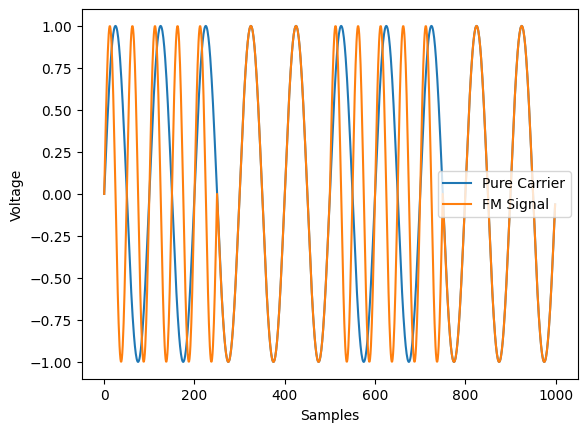

In [12]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt

sample_rate_hz = 1e3 # 1 kSps ADC sample rate
carrier_frequency_hz = 10 # 10 Hz carrier (much lower than actual carriers for demonstrational purposes)
capture_duration_s = 1 # Simulate capturing 1 second of data from ADC

message = np.array([2 * math.pi * 10] * 250 + [0] * 250 + [2 * math.pi * 10] * 250 + [0] * 250) # 1000 samples representing the signal 1010, where each bit lasts 250 samples. 10 Hz is our "1" bit and 0 Hz is our "0" bit.

sample_times_s = np.arange(0, capture_duration_s, capture_duration_s / sample_rate_hz) # Timestamps in seconds each ADC sample
pure_carrier_signal = np.sin(2 * math.pi * carrier_frequency_hz * sample_times_s) # V(t) = sin(omega_carrier * t)
pm_signal = np.sin((2 * math.pi * carrier_frequency_hz + message) * sample_times_s) # V_PM(t) = sin(omega_carrier * t + m(t))

plt.plot(pure_carrier_signal, label = "Pure Carrier")
plt.plot(pm_signal, label = "FM Signal")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Voltage")
plt.show()

Now we're getting somewhere! We can see that in the "1" regions, the frequency of the FM signal increases (there are more peaks). In the "0" regions, it matches the carrier's frequency. Note that I have chosen a very large (relative to the carrier) frequency deviation of 10 Hz to make the plot look more obvious.

__This shows us that causing an increase in frequency requires us to create a _constantly-increasing phase_ (recall that _phase_ is the value we pass to the $ sin() $ function).__

Above, we did this by increasing $ \omega $ to $ \omega + m(t) $. This turns out to not be quite right to create a nice continuous signal--note the weird jumps. The truly correct way is to integrate $ m(t) $ over time. Intuitively, if a constantly-increasing phase is an increased frequency, it makes sense that we would use an integral:

$$ V_{\text{FM}}(t) = \sin \left( \omega_{\text{carrier}} t + 2 \pi k_f \int_0^t m(\alpha) \mathrm{d} \alpha \right) $$

$ k_f $ is the _FM deviation_, the amount that a unit of baseband signal deviates the instantaneous frequency. For broadcast FM, this is 75 kHz.

$ \alpha $ is just an integration variable.

__In general, frequency is the derivative of phase, so phase is the integral of frequency.__

[Take a look at this Reddit post about why we need the integral to be truly correct](https://www.reddit.com/r/DSP/comments/gkoz85/is_there_an_intuitive_explanation_for_why_we/)

Let's generate the above signal again using the integral ([source](https://dsp.stackexchange.com/a/83179)):

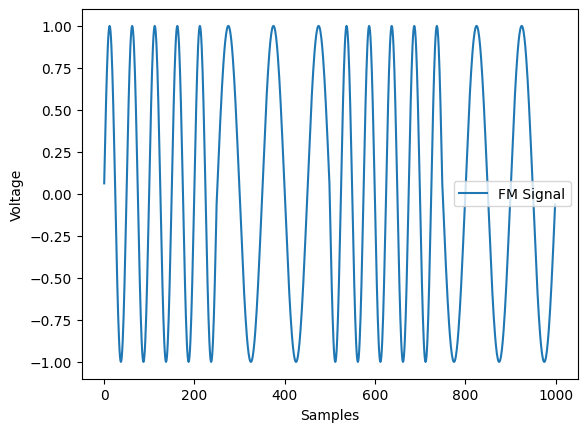

In [13]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt

sample_rate_hz = 1e3 # 1 kSps ADC sample rate
carrier_frequency_hz = 10 # 10 Hz carrier (much lower than actual carriers for demonstrational purposes)
capture_duration_s = 1 # Simulate capturing 1 second of data from ADC

message = np.array([1] * 250 + [0] * 250 + [1] * 250 + [0] * 250) # 1000 samples representing the signal 1010, where each bit lasts 250 samples. 10 Hz is our "1" bit and 0 Hz is our "0" bit.

sample_times_s = np.arange(0, capture_duration_s, 1 / sample_rate_hz) # Timestamps in seconds each ADC sample
pure_carrier_signal = np.sin(2 * math.pi * carrier_frequency_hz * sample_times_s) # V(t) = sin(omega_carrier * t)
deviation_factor_kf = 2 * math.pi * 10 # 10 Hz deviation (exaggerated for better visibility)
phase_modulating_signal = (deviation_factor_kf * np.cumsum(message)) / sample_rate_hz
fm_signal = np.sin((2 * math.pi * carrier_frequency_hz) * sample_times_s + phase_modulating_signal) # V_PM(t) = sin(omega_carrier * t + integral(m(t), 0, t))

#plt.plot(pure_carrier_signal, label = "Pure Carrier")
plt.plot(fm_signal, label = "FM Signal")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Voltage")
plt.show()

Now we see the frequency of the FM signal is varying according to the message signal without weird jumps. Let's try to generate some synthetic I/Q data of what broadcast FM would look like.

## Generating Synthetic I/Q Data of (Mono) Broadcast FM

In [14]:
# Load some example audio (4 seconds of speech)

import math
import scipy
import numpy as np
import matplotlib.pyplot as plt

baseband_sample_rate_hz, baseband = scipy.io.wavfile.read("quick_brown_fox.wav") # 44.1 kSps recording of voice, 16-bit stereo audio
baseband = baseband.astype(np.float32) # Convert to float
baseband = baseband[:,0] + baseband[:,1] # Sum left and right stereo channels to get a single mono channel
baseband /= np.max(baseband) - np.min(baseband) # Make sure amplitude is 1.0.
baseband_filter = scipy.signal.firwin(512, 15e3, fs = baseband_sample_rate_hz).astype(np.float32) # Filter everything above 15 kHz out of the baseband
baseband = scipy.signal.lfilter(baseband_filter, [1.0], baseband).astype(np.float32) # Filter everything above 15 kHz out of the baseband

#baseband = np.sin(2 * math.pi * (15e3 / baseband_sample_rate_hz) * np.arange(0, len(baseband))) # Alternative baseband signal (test 15 kHz tone)

# Upsample to the sample rate we want to generate data at (ADC sample rate)
adc_sample_rate_hz = 64e6 # 64 MSps sampling
baseband_duration_s = len(baseband) / baseband_sample_rate_hz # Duration of baseband recording in seconds
upsample_factor = int(adc_sample_rate_hz / baseband_sample_rate_hz) # 44.1 kSps does not integerly upsample to 64 MSps, so this will be a little wrong (sped-up/slowed-down audio)
baseband = scipy.signal.resample_poly(baseband, upsample_factor, 1)

# Modulate the audio onto a carrier
# See https://wirelesspi.com/frequency-modulation-fm-and-demodulation-using-dsp-techniques/
# See https://engineerstutor.com/wp-content/uploads/2020/10/FM_Frequency_Modulation_EngineersTutor.pdf
carrier_frequency_hz = 5e6 # +5 MHz carrier
carrier_frequency_omega_discrete = (2 * math.pi * carrier_frequency_hz) / adc_sample_rate_hz # Carrier frequency in discrete
fm_deviation_hz = 75e3 # Standard FM deviation for American broadcast FM stations
deviation_factor_kf = 2 * math.pi * fm_deviation_hz # FM deviation in rad/sec
phase_modulating_signal = (deviation_factor_kf * np.cumsum(baseband)) / adc_sample_rate_hz # Discrete integral of frequency is phase
fm_signal_complex = np.e ** (1j * (carrier_frequency_omega_discrete * np.arange(0, len(baseband)) + phase_modulating_signal)) # Complex equivalent of the formula used in the above section
fm_signal_complex = fm_signal_complex.astype(np.complex64)

128000000


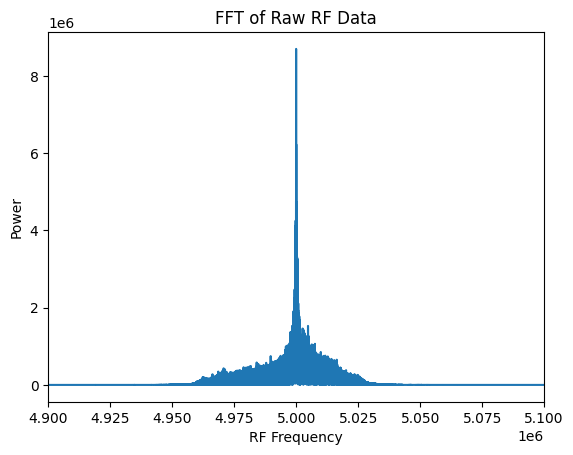

In [15]:
#%matplotlib widget
#plt.clf()

n = int(2 * adc_sample_rate_hz) # Number of samples in 2 seconds of data
print(n)
fft = abs(np.fft.fftshift(np.fft.fft(fm_signal_complex[0:n],n))) # abs() takes the magnitude. Magnitude of the Fourier-transformed data is the power at each frequency bin.

# Plot Fourier transform
frequency_bins = np.linspace(-adc_sample_rate_hz / 2.0, adc_sample_rate_hz / 2.0, n, endpoint = False) # We call the center 0 Hz. For 64 MSps, then our data goes from -32 MHz to +32 MHz
plt.plot(frequency_bins, fft)
plt.xlim(4.9e6, 5.1e6)
plt.title("FFT of Raw RF Data")
plt.xlabel("RF Frequency")
plt.ylabel("Power")
plt.show()

# Making it Look Like RFSoC Data

In the configuration we used for lab 6 and 7, the RF-ADC is capturing at 64 MSps, which we already generated the above data at. But we still need to make it into 16-bit signed integers (and optionally add some noise) to make it look more like actual captured data.

The above data was generated with a magnitude of exactly 1.0. Let's generate Gaussian (white) noise and add it:

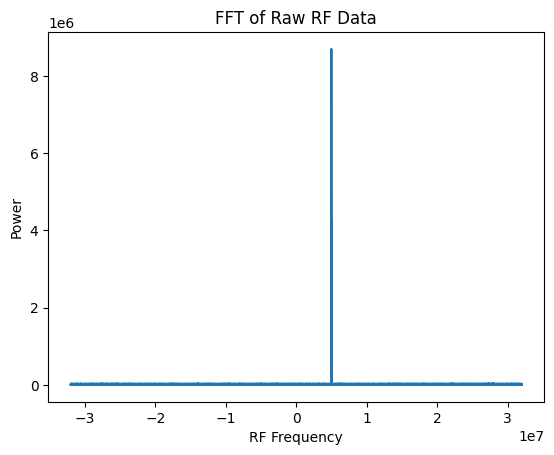

In [16]:
# See https://stackoverflow.com/a/55700398
noise = np.random.randn(len(fm_signal_complex), 2).view(np.complex128)[:,0] * 0.5
#fm_signal_complex += noise
fm_signal_noisy = (fm_signal_complex + noise).astype(np.complex64)

# Plot Fourier transform
n = int(2 * adc_sample_rate_hz) # Number of samples in 2 seconds of data
fft = abs(np.fft.fftshift(np.fft.fft(fm_signal_noisy[0:n],n))) # abs() takes the magnitude. Magnitude of the Fourier-transformed data is the power at each frequency bin.

frequency_bins = np.linspace(-adc_sample_rate_hz / 2.0, adc_sample_rate_hz / 2.0, n, endpoint = False) # We call the center 0 Hz. For 64 MSps, then our data goes from -32 MHz to +32 MHz
plt.plot(frequency_bins, fft)
#plt.xlim(4.9e6, 5.1e6)
plt.title("FFT of Raw RF Data")
plt.xlabel("RF Frequency")
plt.ylabel("Power")
plt.show()

In [17]:
# Save the complex FM signal as a raw I/Q data file in cf32 format (must be an array of np.complex64 for this), which is readable by Gqrx and other SDR software.
fm_signal_noisy.tofile("quick_brown_fox_at_5_mhz_plusnoise.raw")

In [18]:
# Scale and convert the complex FM signal to numbers that make sense as 16-bit signed integers. Numpy doesn't have a complex integer type, so we are saving these as complex64, but you shold convert them to streams of int16 when loading them.
fm_signal_scaled_rounded = np.round(fm_signal_noisy * 30000).astype(np.complex64)

np.save("quick_brown_fox_at_5_mhz_plusnoise.npy", fm_signal_scaled_rounded)

In [5]:
def iq_plot(time_sec,re_signal,im_signal,n_samples,):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples],re_signal[:n_samples],'y-o',label='I signal')
    plt.plot(time_sec[:n_samples],im_signal[:n_samples],'g-o',label='Q signal')
    #plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-o',label='Input signal')

    plt.legend()

fixed_point = 1
def pack_32bits(high,low):
	return ((int(high*fixed_point) & 0xFFFF) << 16) | (int(low*fixed_point) & 0xFFFF)

def nunmpy_to32bit(complexy):
	return pack_32bits(np.real(complexy),np.imag(complexy))

    

In [1]:

from scipy.signal import firwin
from IPython.display import Audio
import numpy as np
data = np.load(r"quick_brown_fox_at_5_mhz_plusnoise.npy").astype(np.complex64) / 30000 # undoing the scaling
act_data = data

c_data = 0.5*np.angle(act_data[0:-1]*np.conj(act_data[1:]))

# mix down with 5 MHz signal at 64 Msps at the same length of the audio signal
# low pass filter and figure out the lpf cutoff
# 

#taps = firwin(numtaps=101, cutoff=6.25e3, fs=250e3) #make another anti-alias filter for 20X decimation

#c_data = np.convolve(c_data, taps, 'valid') #apply filter!
c_data=c_data[::1845] #downsample to 12.5 ksps (factor of 20)
print(len(c_data))
Audio(data=c_data.real, rate=44.1e3) #make audio signal at 12.5 ksps (use real component)


132275


In [18]:
import numpy as np
import scipy.signal

# --- Your known parameters ---
adc_sample_rate_hz = 64e6
carrier_frequency_hz = 5e6
fm_deviation_hz = 75e3
baseband_sample_rate_hz = 44_100

# --- Your FM data (already complex64) ---
# fm_signal_recovered = fm_signal_scaled_rounded / 30000.0  # from earlier quantization step

# --- 1. Mix down to baseband (remove 5 MHz carrier) ---
n = np.arange(len(act_data))
mix = np.exp(-1j * 2 * np.pi * carrier_frequency_hz * n / adc_sample_rate_hz)
baseband = act_data * mix

# --- 2. FM demodulate (phase discriminator) ---
# Compute instantaneous phase difference
b, a = scipy.signal.butter(3, 3e5 / (0.5 * adc_sample_rate_hz))
dm_filtered = scipy.signal.lfilter(b, a, baseband)

# this is our signal cool

phase_diff1 = np.angle(np.conj(dm_filtered[:-1]) * dm_filtered[1:])
dm_filtered=np.angle(dm_filtered)
#our ghetto demodulation scheme


angle_1 = dm_filtered[1:]-dm_filtered[:-1]
for i in range(len(angle_1)):
    if(angle_1[i]>np.pi):
            angle_1[i]=angle_1[i]-2*np.pi
    elif(angle_1[i]<-np.pi):
            angle_1[i]=angle_1[i]+2*np.pi
        
phase_diff2 = angle_1


# --- 4. Decimate from 64 MHz down to 44.1 kHz ---
# Decimation ratio is large, so use resample_poly for efficiency
audio_44k1 = scipy.signal.resample_poly(phase_diff1, baseband_sample_rate_hz, int(adc_sample_rate_hz),window=('kaiser', 8.6))
audio_44k12 = scipy.signal.resample_poly(phase_diff2, baseband_sample_rate_hz, int(adc_sample_rate_hz),window=('kaiser', 8.6))


Audio(data=audio_44k1, rate=44.1e3)



In [17]:
Audio(data=audio_44k12, rate=44.1e3)

In [14]:
print(np.degrees(phase_diff1[:500]))

[-3.73163809e+00 -2.18249493e+00 -6.65003072e-01 -1.14460517e-01
 -2.53264053e-01 -3.94769998e-01 -3.86391750e-01 -3.40309562e-01
 -3.03956156e-01 -2.45733655e-01 -1.39644207e-01 -4.37601380e-02
 -1.58744093e-02 -4.36391974e-02 -8.52013463e-02 -1.07754437e-01
 -1.05889389e-01 -9.86568678e-02 -9.58307374e-02 -9.25547488e-02
 -9.28738420e-02 -1.00640008e-01 -1.05286926e-01 -9.73057471e-02
 -7.83885163e-02 -5.64608780e-02 -4.19515788e-02 -4.03944041e-02
 -4.59371175e-02 -4.99873687e-02 -5.32168490e-02 -6.01653897e-02
 -6.84757225e-02 -7.40202131e-02 -7.71853267e-02 -8.06441599e-02
 -8.72800037e-02 -9.53073755e-02 -1.00360536e-01 -1.02820503e-01
 -1.04511271e-01 -1.05159543e-01 -1.04500982e-01 -1.03134042e-01
 -1.01386531e-01 -9.89191311e-02 -9.64285486e-02 -9.57020092e-02
 -9.72139510e-02 -9.95738577e-02 -1.02008092e-01 -1.04875512e-01
 -1.07438615e-01 -1.08845137e-01 -1.10223664e-01 -1.13076523e-01
 -1.17079488e-01 -1.21054956e-01 -1.24886013e-01 -1.28698463e-01
 -1.31856645e-01 -1.34134

In [11]:
print(phase_diff2[:100])

[6.21805594 6.24509358 6.27157881 6.28118759 6.27876502 6.27629527
 6.2764415  6.27724578 6.27788027 6.27889645 6.28074806 6.28242155
 6.28290825 6.28242366 6.28169826 6.28130464 6.28133719 6.28146342
 6.28151275 6.28156992 6.28156435 6.28142881 6.2813477  6.281487
 6.28181717 6.28219988 6.28245311 6.28248029 6.28238355 6.28231286
 6.2822565  6.28213522 6.28199018 6.28189341 6.28183817 6.2817778
 6.28166198 6.28152188 6.28143369 6.28139075 6.28136124 6.28134993
 6.28136142 6.28138528 6.28141578 6.28145884 6.28150231 6.28151499
 6.2814886  6.28144742 6.28140493 6.28135488 6.28131015 6.2812856
 6.28126154 6.28121175 6.28114188 6.2810725  6.28100564 6.2809391
 6.28088397 6.28084422 6.2808136  6.28079796 6.28080347 6.28081982
 6.28084558 6.28088784 6.28093721 6.28098206 6.28102639 6.2810711
 6.28109702 6.28109575 6.28109174 6.2811043  6.28112789 6.28115978
 6.28120899 6.28127862 6.28135319 6.28140853 6.28143838 6.28145901
 6.28148753 6.28152567 6.28156419 6.28159978 6.28163526 6.28167393
 